Neuromorphic engineering I

# Photo and DVS lab


<div markdown="1" style=" width: 800px; border: 1px solid red; border-radius: 5px; /*background-color: #d1a2a2; */ margin: 1em 0 1em 4em; padding: 1em 1em 0.5em 1em">

**Reminder: Did you `git pull` the exercises before starting this notebook?**.
</div>

Team member 1: 

Team member 2: 

Date: 

-------------------------------------------------------------------------------------------------------------------

### Lab objectives

The objectives of this lab are to understand and simulate **logarithmic photoreceptor circuit dynamics** and understand and measure a **dynamic vision sensor** (**DVS**) pixel.

The prelab objectives are as follows:
1. [To analyze](#photoreceptor-dynamics) the expected bandwidth of the transimpedance (**TI**) log photoreceptor of the DVS pixel by comparison with a simple source-follower (**SF**) log photoreceptor, by deriving the small signal photoreceptor transfer functions.
2. [To describe](#dvs-pixel-event-theory-week-2) at a high level the operation of the DVS pixel, compute the gain of each stage of the DVS pixel circuit, and compute the expected temporal contrast threshold given a set of bias currents.
   
The experimental objectives consist of physical experiments with the CoACH chip and simulations of the photoreceptor. They are as follows:
1. Simulations:
   1. To understand how to [compute expected levels of actual photocurrents](#estimating-actual-photocurrent-with-photometry).
   2. To [write a simulator](#simulation-setup) based on ideal transistor equations
   3. To [do large signal simulations](#exercise-2-large-signal-transient-response-of-source-follower-and-active-photoreceptors) of SF and TI photoreceptors to compare their dynamics.
2. Coach chip: 
   1. To [find the noise threshold](#exercise-1-measuring-dvs-noise) of a DVS pixel in the dark and to measure the effect of bandwidth on DVS noise in the dark.

**This exercise will take 2 weeks.** 

--------------------------------

# Setup

You may want to install all the necessary requirements (python libraries)

In [ ]:
import sys
!{sys.executable} -m pip install -r requirements.txt --upgrade # note upgrade to update jupyter-save-load-vars
# you may need to restart kernel if new libraries got installed.

<font color=#108ee9 markdown="1">

* Import necessary python libraries.
</font> The cell below may be collapsed.

In [ ]:
import time # for time.sleep(seconds)
import numpy as np # numpy for arrays etc
from scipy import stats # for stats.linregress
import matplotlib
import matplotlib.pyplot as plt # for plotting
import matplotlib
plt.rcParams.update({'font.size': 10}) # make the detault font size larger for your readers
matplotlib.rcParams['pdf.fonttype'] = 42 # save fonts as type that are not outlined in illustrator or other drawing programs
from engineering_notation import EngNumber as ef # format numbers in engineering format quickly, e.g. ef(2e-9)='2n' https://pypi.org/project/engineering-notation/
from pathlib import Path # used for saving data

datapath = Path('data/dvs') # make a data folder to save your data called data/lab5
datapath.mkdir(parents=True, exist_ok=True)
from jupyter_save_load_vars import savevars, loadvars
from tqdm import tqdm

import pyplane # for type hinting of biasgen constants
from ne1 import Coach # import Coach() class
import logging
p=Coach(logging_level=logging.INFO) # NOTE change to INFO to reduce clutter - create a Coach object called p; you will use it to talk to class chip, change to logging.DEBUG for troubleshooting
# p.open()

# below lines are notebook magic for debugging, you can uncomment them when debugging the Coach() class
# %load_ext autoreload
# %autoreload explicit
# %aimport ne1


<font color=#108ee9 markdown="1">

* Check if the board is available and that you can set up the DVS pixel.
</font>
You can come back to this later if you are working on the prelab.

In [ ]:
try:
    p.open() # test it
    p.setup_dvs() # configure DVS pixel
finally:
    p.close()

 <font color=#108ee9 markdown="1">

* Note the values of the DVS bias currents that are printed out as part of the setup. The directly relate to the DVS <u>[abstract](#fig-1-dvs-pixel-and-operation)</u> and <u>[real](#fig-21-the-coach-dvs-pixel-schematic-from-the-chip-design-report)</u> pixel schematics. You may need to modify them later.
</font>
   * Note that the cascode FET $M_{\rm cas}$ gate voltage is generated by a bias current generator.

# 1 Prelab

<div markdown="1" style=" width: 1000px; border: 2px solid red; border-radius: 5px; /*background-color: #d1a2a2; */ margin: 0px; padding: 10px ">

**This prelab is long.** You may want to work on it before and after collecting experimental data from the CoACH DVS pixel.
</div>

### Photoreceptor dynamics theory (week 1)

Compare the 2 circuits sketched below.
The left one is the _simple_ or _source-follower_ (**SF**) photoreceptor
and the right one is the unity-gain active _feedback_ or _transimpendance_ feedback (**TI**) photoreceptor.

<div markdown="1" style=" width: 800px; border: 1px solid blue; border-radius: 5px; /*background-color: #d1a2a2; */ margin: 1em 0 1em 4em; padding: 1em 1em 0.5em 1em">

The SF circuit is also called a _common-gate_ photoreceptor because the gate voltage $V_b$ is usually common to all photoreceptors on a chip. We call it a source-follower photoreceptor because it looks like 
the source follower you are familiar with from previous labs; the output voltage $V_o$ follows the reference voltage $V_b$, but it does not follow the photocurrent.

A _transimpedance_ circuit turns current into voltage; we use the term here to imply that the TI circuit is active, meaning it uses a separate feedback amplifier to speed up the response and lower the output impedance..
</div>

<img src='figs/lab9_photoreceptor1.jpg' width=600>

The definitions in <font color=magenta> magenta</font> color are useful for shorter equations.

#### Fig. 1.2: The SF and TI photoreceptors


You will compare the dynamics of the responses of the SF and TI circuits to understand how the TI circuit speeds up the response.

<div markdown="1" style=" width: 800px;  border: 1px solid blue; border-radius: 5px; /*background-color: #d1a2a2; */ margin: 1em 0 1em 4em; padding: 1em 1em 0.5em 1em">

In each circuit the total photocurrent $I_{pd}=I_{bg}+i$, where a small signal $i$ is added to a background photocurrent $I_{bg}$. The output of each circuit is $V_{out}$, which is the same as $V_p$ in [the DVS pixel circuit](#fig-1-dvs-pixel-and-operation). We formulate the photocurrent this way because we are interested in the small signal response characteristics, and so that we can formulate the input **temporal contract** ${\rm TC}$ as: 
$$
{\rm TC}=\frac{i}{I_{\rm bg}}
$$.
</div>

#### Photoreceptor dynamics

<font color=#108ee9 markdown="1">

* Write the large signal dynamical equations for the SF and TI photoreceptors.
</font> Your equations should express $\dot{V}=f(V)$ for each node voltage $V$ in the circuit.  You can ignore all terms that are not important here, e.g. the photodiode Early effect (its 'conductance'), and all Miller capacitors. You can use voltages in units of $U_T$ so you don't need $U_T$ in your equations. 

You can use the saturated subthreshold current $I=I_0 \exp(\kappa V_g-V_s)$ everywhere.

For the TI circuit, you can express the $M_n$-$M_p$ feedback amplifier output conductance as $g_o$. Since this conductance results from the Early effects in $M_n$ and $M_p$, it is proportional to the bias current $I_b$ and some equivalent parallel Early voltage $V_e$, i.e. $g_o=I_b/V_e$. These drain conductances are the only ones that matter in the circuit. 

You will use this result in [the large signal simulation of the TI photoreceptor](#3-dvs-photoreceptor-simulation-experiments).

<div markdown="1" style=" width: 900px; border: 1px solid purple; border-radius: 5px;  margin: 1em 0 1em 4em; padding: 1em 1em 0.5em 1em">

Answer: 
</div>

<font color=#108ee9 markdown="1">

* From these large signal equations, derive the small signal versions $\dot{v}=f(v)$ (where we use the lower case $v$ to mean small signal) by assuming that the circuit operates around a DC operating point determined by $I_{bg}$ and $I_b$ or $V_b$.
</font>
Using thermal voltage units, the subthreshold FET conductances are $g_s=I$ for source conductance and $g_m=\kappa I$ for gate transconductance, where $I$ is the DC current through the transistor.  You can use the shorthands that $C_{out}=C_o$, $v_p=v_{pd}$, $v_o=v_{out}$ etc.

<div markdown="1" style=" width: 900px; border: 1px solid purple; border-radius: 5px;  margin: 1em 0 1em 4em; padding: 1em 1em 0.5em 1em">

Answer: 
</div>

<font color=#108ee9 markdown="1">

* Now substitute $\dot{v}=s v$ and use time constants computed from the currents and capacitances,
</font> e.g. for the SF circuit, $\tau_{pd} \equiv \tau_p=C_{out}/I_{bg}$. For the TI circuit, there is one input node time constant $\tau_{pd}\equiv \tau_p \equiv C_{pd}/I_{bg}$. For the output node $v_{o} \equiv v_{out}$, there are really two possible time constants
1. $\tau_{g} \equiv C_{o}/g_{m,M_n}$. It describes how quickly the output reacts to changes in the input voltage $v_p$.
2. $\tau_{o} \equiv r_o C_{out} = C_o/g_o$. It describes how quickly the output $v_o$ recovers from a disturbance. **It is better to use $\tau_{o}$, because then the amplifier can be described by a simple lowpass filter.**
   
Note that if you use voltages in units of $U_T$, then conductances are expressed as current (i.e. currents have same units as conductance) and then a time constant $\tau$ can be either $C/g$ or $C/I$.



<div markdown="1" style=" width: 900px; border: 1px solid purple; border-radius: 5px;  margin: 1em 0 1em 4em; padding: 1em 1em 0.5em 1em">

Answer: 
</div>

In this form, your equations are expressed in the s-plane and you can quickly derive the $H(s)$ transfer functions that are expressed with the circuit time constants, at least for the SF circuit. 

<font color=#108ee9 markdown="1">

* Compute the small signal transfer functions $H_{SF}$ from $i$ to $V_{out}$, i.e. $H(s)=v_{out}(s)/(i(s)/I_{bg})$. 
</font>


<div markdown="1" style=" width: 900px; border: 1px solid purple; border-radius: 5px;  margin: 1em 0 1em 4em; padding: 1em 1em 0.5em 1em">

Answer: $H_{\rm SF}$ is given in the previous answer by division of $v/(i/I_{\rm bg})$.  It is a 1st order lowpass filter with a time constant $\tau=C_o U_T/I_{\rm bg}$. The darker it is, the slower it reacts. E.g. if $I_{\rm bg}=100{\rm fA}$ and $C_o=100{\rm fF}$, the $\tau=25{\rm ms}$. That corresponds to a cutoff frequency of $f_{\rm 3dB}=1/(2 \pi \tau)=6.4{\rm Hz}$.
</div>

<font color=#108ee9 markdown="1">

* From the generic negative feedback circuit sketched here with forward inverting gain $-a(s)$ (_note the minus sign_) and (passive) feedback $b(s)$, compute the transfer function $H(s)=y/x$ where $x$ is the input and $y$ is the output.
  
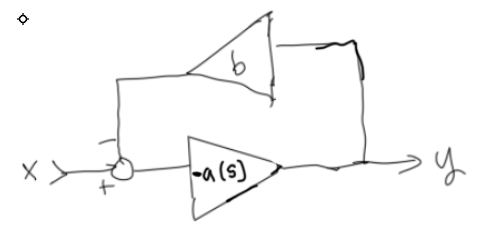
</font>

You should end up with
$$
y=\frac{-x/b}{1+\frac{1}{ab}}
$$
where we write it this way to express the fact that $a\gg 1$ and $b\lt 1$. Thus if $ab\gg 1$, the gain $y/x$ simplifies to $x/y=-x/b$ and the big forward gain simply disappears, so that the total closed-loop gain depends only on (often) passive, well-controlled feedback elements.



<div markdown="1" style=" width: 900px; border: 1px solid purple; border-radius: 5px;  margin: 1em 0 1em 4em; padding: 1em 1em 0.5em 1em">

Answer: 


</div>

<font color=#108ee9 markdown="1">

* From the small signal equations you computed earlier and (perhaps, if you like) using Black's formula, compute the small signal transfer function $H_{TI}$ from $i$ to $V_{\rm out}$, i.e. $H(s)=v_{\rm out}(s)/(i(s)/I_{bg})$. 
</font> 

The input to the circuit is the small-signal photocurrent $i_{pd}$ which is its deviation from
the DC value $I_{pd}$. The output is the small signal output voltage $v_{\rm out}$. 
Since the circuit is a log photoreceptor, a better way to express the transfer function
is to write it as output voltage per log input current. Thus $H(s)$ will be the transimpedance
**_conversion gain_** that transduces from $i_{\rm pd}/I_{\rm bg}$ to $v_{\rm out}$, i.e.
the units of H(s) are volts/(fractional change in current).

You might start by deriving the functions $a(s)$ and $b(s)$. Handling the input is a bit tricky because the input $x$ is the small signal current $i$.  
Assume that $a(s)$ defines the conversion gain from $i$ to $v_p$.
1. You can sketch the small signal circuit equivalents for $v_p$ and $v_o$ that show all sources that contribute to these small signal voltages. From these it is easy to write the ODEs.
2. Note that the forward gain includes the transduction from $i$ to $v_p$ via the source conductance of $M_{\rm fb}$. 
3. Note that the amplifier gain $A=g_{mn}/g_o$, and assume that $A\gg 1$, so that e.g. $\kappa A+1=\kappa A$.
4. Note also that the SF feedback gain $b$ is simple; it just consists of the $\kappa$ in $M_{\rm fb}$.

_Hints:_ 
1. You can ignore any parasitics that are not shown here, like Miller caps (gate-drain and gate-source overlap). 
2. Your SF transfer function will have two time constants $\tau_{\rm p}=C_{\rm o}/I_{\rm bg}$ (for the photodiode voltage) and $\tau_{\rm o}=C_{\rm o}/g_{\rm o}=C_{\rm o}/(I_{\rm b}/V_{\rm e})$
for the output voltage. 

<div markdown="1" style=" width: 900px; border: 1px solid purple; border-radius: 5px;  margin: 1em 0 1em 4em; padding: 1em 1em 0.5em 1em">

Answer: 

</div>

The TI feedback should make the TI photoreceptor
faster to respond to changes in photocurrent than the SF photoreceptor
(and also noisier).

<font color=#108ee9 markdown="1">

* Compute the expected speedup from the feedback, by setting $\tau_{out}$ to zero (taking the limit as $\tau_{out}$ goes to zero).
</font>

I.e., what is the ratio of cutoff frequency of TI to SF circuit when $I_b$ is really large?
You will see if it true (at least in the model) in the Bode magnitude transfer function plots.


<div markdown="1" style=" width: 900px; border: 1px solid purple; border-radius: 5px;  margin: 1em 0 1em 4em; padding: 1em 1em 0.5em 1em">

Answer: The ratio is ideally $A$, but the Miller caps of next question reduce this improvement considerably..
</div>

<font color=#108ee9 markdown="1">

* Suppose we consider the Miller capacitors $C_{m,fb}$ and $C_{m,n}$ that are sketched here. What will they do to change the conclusions about speedup?

![millers](figs/photo/millers.jpg)

</font>

<div markdown="1" style=" width: 900px; border: 1px solid purple; border-radius: 5px;  margin: 1em 0 1em 4em; padding: 1em 1em 0.5em 1em">

Answer:
</div>

You can now go straight to the [photoreceptor simulation exercises](#3-dvs-photoreceptor-simulation-experiments) if you like.

<!-- Since we cannnot actually shine light onto the chip, we will simulate it by wiggling the $I_{\rm sf}$ current. <font color=#108ee9 markdown="1">

* Show that $I_{\rm sf}$ acts very similarly to $I_{\rm p}$ in terms of generating DVS events. What $\Delta \ln(I_{\rm sf})$ generates an event?
</font> -->

<!-- <font color=#108ee9 markdown="1">

* Given [the actual pixel circuit](#fig-21-the-coach-dvs-pixel-schematic-from-the-chip-design-report), devise a scheme to hold the photoreceptor output at a constant output voltage with low output impedance. 
</font> Hint: the cascode and photoreceptor bias can be set so that the photoreceptor output is clamped at a low voltage. -->


### DVS pixel event theory (week 2)
The following prelab exercises will enable you to compute quantitatively the expected threshold characteristics of the DVS pixel. You can come back to these questions in week 2 of the exercise.

The DVS pixel circuit is shown here from from this [2017 IEEE TED paper about the effect of temperature and parasitic photocurrent in DVS pixels](https://ieeexplore.ieee.org/document/7962235). See [the actual CoACH chip DVS pixel in this figure](#fig-21-the-coach-dvs-pixel-schematic-from-the-chip-design-report).

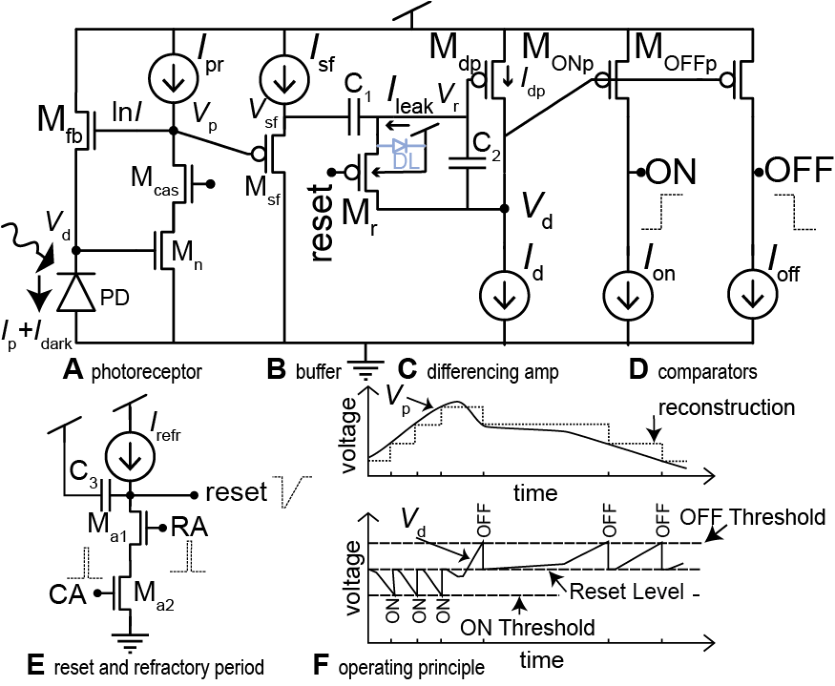


##### Fig. 1: DVS pixel and operation.
(A)–(E) Analog part of DVS pixel circuit. The row and column acknowlege signals (*RA* and *CA*) come from digital handshaking circuits that are part of the digital circuits that communicate with the peripheral
AER readout circuits which are not shown here; (F) Principle of operation. (Adapted from  [2008 IEEE JSSC publication](https://ieeexplore.ieee.org/document/4444573)).

The ON and OFF outputs of the pixel have opposite polarity. The *ON* output is low after reset and goes high when an ON event is detected. The *OFF* output is high after reset and goes low when the pixel detects an OFF event.
There are additional circuits not shown here or in the CoACH DVS pixel schematic that interface the pixel *ON* and *OFF* signals to chip peripheral event readout.

Typical $C_1/C_2$ ratios are about 20.

* <font color=#108ee9>Describe the operation of the DVS pixel in Fig. 1 in words, using the circuit and Fig. 1F illustration.</font> I.e., describe how it produces **brightness change events** (log intensity change events).

<div markdown="1" style=" width: 900px; border: 1px solid purple; border-radius: 5px;  margin: 1em 0 1em 4em; padding: 1em 1em 0.5em 1em">

Answer: 
</div>

There is unavoidable mismatch in all parts of the DVS pixel.  <font color=#108ee9 markdown="1">

* Sketch how the Fig. 1C-D change amplifier and comparators reduce the input-referred mismatch by a factor of $A=C_1/C_2$.
</font> Compare histograms of the comparator and change amplifier mismatches with histograms of the input-referred mismatch at the change amplifier input.

<div markdown="1" style=" width: 900px; border: 1px solid purple; border-radius: 5px;  margin: 1em 0 1em 4em; padding: 1em 1em 0.5em 1em">

Answer: 
</div>

#### DVS temporal contrast threshold

In this part of the prelab you will compute the **temporal contrast threshold** from the capacitor ratio and bias currents.

$I_{\rm pr}$ and $I_{\rm sf}$ are generated by PFETs. $V_p$ depends on $I_{\rm sf}$ and the photocurrent $I_p$. $V_{\rm sf}$ DC level depends additionally on the bias currents $I_{\rm sf}$. The bias voltages $V_{\rm b,pr}$ and $V_{\rm b,sf}$ are generated by the CoACH biasgen, and $I_{\rm pr}=I_0 \exp(\kappa V_{\rm b,pr}/U_T)$. (We assume that PFET biases are relative to Vdd and expressed as positive voltages away from Vdd.)

<font color=#108ee9>

* Compute the small signal static (i.e. DC) response $v_p$ to an input small signal photocurrent $i$ assuming that the Mn amplifier has infinite gain. You can ignore the cascode $M_{\rm cas}$ here and for all the subsequent computations. Assume that $i$ is added to a background photocurrent $I_{\rm bg}$
</font> 

<div markdown="1" style=" width: 900px; border: 1px solid purple; border-radius: 5px;  margin: 1em 0 1em 4em; padding: 1em 1em 0.5em 1em">

Answer: 
</div>

* <font color=#108ee9>Compute the small signal voltage gain of the Fig. 1B source follower</font> formed by $M_{\rm sf}$ and its bias current $I_{\rm sf}$ PFET, assuming some $\kappa$ value. *Hint:* this is just the source-follower from week 2.

See previous

* <font color=#108ee9>Compute the Fig. 1C change amplifier voltage gain</font> $A=v_{\rm d}/v_{\rm sf}$. The change amplifier is formed by $C_1$, $C_2$, $M_{dp}$ and its bias current sink $I_d$ when the reset switch $M_r$ is disconnected, i.e. when the pixel is detecting brightness changes. You can assume that the $M_{\rm dp}$ FET amplifier has infinite open-loop gain.

<div markdown="1" style=" width: 900px; border: 1px solid purple; border-radius: 5px;  margin: 1em 0 1em 4em; padding: 1em 1em 0.5em 1em">

Answer: 
</div>

<font color=#108ee9 markdown="1">

* Compute the voltage change threshold at the change amplifier input $v_{\rm sf}$ to make an ON or OFF event at the comparator outputs _ON_ and _OFF_.
</font>
You can assume that the Fig. 1D ON and OFF FET comparators have infinite gain. Your solution should be expressed in terms of the bias currents $I_{\rm d}$, $I_{\rm on}$, and $I_{\rm off}$ where $I_{\rm on} > I_{\rm d} >I_{\rm off}$. You can assume subthreshold operation and that $\kappa \equiv \kappa_n=\kappa_p$. You can also ignore any possible charge injection onto $V_{\rm r}$ from turning off the reset switch $M_{\rm r}$.

<div markdown="1" style=" width: 900px; border: 1px solid purple; border-radius: 5px;  margin: 1em 0 1em 4em; padding: 1em 1em 0.5em 1em">

Answer: 
</div>

* From the previous results, <font color=#108ee9>compute the **temporal contrast thresholds** </font> $\theta_{\rm on}$ and $\theta_{\rm off}$ for making a single ON or OFF event given  $\theta$ will be expressed in natural log units, i.e. the $\theta=\Delta \ln(I_{\rm p})$ to make a single event. Assume that $\kappa \equiv \kappa_n=\kappa_p$.


<div markdown="1" style=" width: 900px; border: 1px solid purple; border-radius: 5px;  margin: 1em 0 1em 4em; padding: 1em 1em 0.5em 1em">

Answer: 
</div>

#### DVS refractory period
The _refractory period_ is a duration of time that the pixel ignores changes in log intensity after it make an event. It is useful [in automatic event rate control algorithms](https://ieeexplore.ieee.org/document/9522899) for limiting the event rate because modifying it does not produce events.

<font color=#108ee9 markdown="1">

* For the Fig. 1E refractory period control circuit that holds the reset switch connected for a period of time after each event is generrated, compute the time $t_{\rm refr}$ that the _reset_ pulse stays more than $V_T$ from Vdd given the bias current $I_{\rm refr}$ and capacitance $C_3$. 
</font> You can assume that *reset* starts charging high once both signals *CA* and *RA* (column acknowledge and row acknowledge) go low.

<div markdown="1" style=" width: 900px; border: 1px solid purple; border-radius: 5px;  margin: 1em 0 1em 4em; padding: 1em 1em 0.5em 1em">

Answer: 
</div>

<font color=#108ee9 markdown="1">

* Given <u>[the actual pixel circuit](#fig-21-the-coach-dvs-pixel-schematic-from-the-chip-design-report)</u> and the process technology value of  $C_{ox}=9{\rm fF/um^2}$ (the gate capacitance), what  $I_{\rm refr}$ do we need to result in a $t_{\rm refr}<1{\rm ms}$? 
</font>
You will use this value to set the DVS pixel $I_{\rm refr}$ .

<div markdown="1" style=" width: 900px; border: 1px solid purple; border-radius: 5px;  margin: 1em 0 1em 4em; padding: 1em 1em 0.5em 1em">

Answer: 
</div>


#### DVS noise

At low light intensity and with a low event threshold, DVS pixels make a lot of noise events that are mainly caused by quantal photon and electron flow (shot noise).  The whole phenomenon is simple, but the theory is complicated because it must use time-of-crossing stochastic equation analysis. Here we will sketch out a few of the main ideas, which you will explore in the CoACH DVS pixel experiments.

<font color=#108ee9 markdown="1">

* Sketch possible shapes of the DVS photoreceptor $V_p$ noise spectrum and the $V_{sf}$ noise spectrum, assuming that the source follower low pass filters the photoreceptor output noise.
</font>

<div markdown="1" style=" width: 900px; border: 1px solid purple; border-radius: 5px;  margin: 1em 0 1em 4em; padding: 1em 1em 0.5em 1em">

Answer: 
</div>

<font color=#108ee9 markdown="1">

* Sketch a possible shape of the noise event rate $R_n$ vs the source follower bandwidth $B$.
</font>

<div markdown="1" style=" width: 900px; border: 1px solid purple; border-radius: 5px;  margin: 1em 0 1em 4em; padding: 1em 1em 0.5em 1em">

Answer: 
</div>

# 2 CoACH DVS pixel experiments

<div markdown="1" style=" width: 1000px; border: 1px solid blue; border-radius: 5px; /*background-color: #d1a2a2; */ margin: 1em 0 1em 4em; padding: 1em 1em 0.5em 1em">

These experiments are probably better done in week 2, but we list them here so you can see the pixel circuits earlier.

You may want to skip to [the photoreceptor simulation exercises](#3-dvs-photoreceptor-simulation-experiments) for the first week of this exercise unless you would rather make sure you can obtain experimental results from the chip.
</div>





#### Fig 2.1 The CoACH DVS pixel schematic, from the chip design report.

![dvs_pixel.png](figs/photo/dvs_pixel.png)


The only DVS pixel output we can observe are the digital ON and OFF events; there are no internal nodes instrumented to read the analog voltages. Just like in many neuroscience experiements, we must infer what is going on from these spike events.

We would like to measure the response of the DVS pixel to light input.
The Plane PCB has a header designed to drive an LED that we could place over the chip.
Unfortunately, the CoACH chips are covered with an opaque cover that is glued on. The cover can be removed with a heat gun and a bit of gentle pushing, but taking it off exposes the bare bonding wires that are easily damaged by the touch of a finger. 

However, one possibility to simulate a light input is by wiggling the photoreceptor or source follower biases, which causes the output to move around as though the intensity were changing.  **Unfortunately, it seems that any change of bias causes a lot of internal noise that totally masks out the desired observation of the effect of the change of the bias current.**  We left the development code in git history for future tries.

Since we cannot take the lids off the CoACH chips, we will do an experiment to measure DVS event noise as a function of the source-follower buffer lowpass filter. The aim is to observe the reduction of noise when we reduce the bandwidth of the source follower to filter out the high frequencies of the photoreceptor shot noise.

<!-- In the prelab, you already computed the gains of the various stages. Here we will use this theory to stimulate the pixel and see if it produces the expected number of events. We will simply bypass the photoreceptor and directly modulate $I_{\rm sf}$. -->


## Exercise 1: Measuring DVS noise

Instead, let's see if we can measure photoreceptor shot noise by setting a lower and lower event threshold and just recording the increasing noise events coming out until we get too many.
At a certain point the event rate even from one pixel overwhelms the CoACH USB interface and can cause the Python machine to crash, so we need to be cautious about how we approach this threshold.

1. We will record multiple packets of events, each time after setting the threshold to a new value.
2. To work around problems with `request_coach_output_events` for long request durations we capture just short packets and assemble them to the final events.

We will start by using the code below to gradually reduce the event threshold until a certain level of noise is reached.  If your Python kernel crashes, use [this link to go back to the library import setup](#setup). Or if you are using _vscode_, you can split the notebook window and keep the import cell handy.

In [ ]:
from ne1 import Coach # reload for debugging TODO comment this

def find_minimum_dvs_threshold(threshold_noise_rate_hz=100):
    """ 
    Tests multiple calls to get events, terminates when event rate exceeds some threshold
    
    :param coach: the Coach instance
    :param threshold_noise_rate_hz: when to stop decreasing threshold

    :return: the on_off_ratio just before termination of test
    """
    ratio=2.5                      # the initial value of Ion/Idiff and Idiff/Ioff NOTE you might need to change this for your chip
    c=Coach()
    c.open()
    ipr,isf,icas,idiff,ion,ioff,irefr=c.setup_dvs(on_off_ratio=ratio)

    ratio_decrease_factor=.95       # by what factor to decrease it each iteration
    t_capture_total_s=2             # total capture time for one threshold
    t_capture_split_number=5      # how many times we capture and append for one threshold  to try to avoid bombing python machine within pyplane
    dt = float(t_capture_total_s)/t_capture_split_number
    
    n_max=threshold_noise_rate_hz*t_capture_total_s/t_capture_split_number   # max number of events per capture_coach_output_events
    
    print(f'Testing repeated captures from DVS with decreasing threshold values starting from {ratio} and decreasing by powers of {ratio_decrease_factor} until we capture {n_max} events')
    # c.set_debug(True) # comment in to see detailed low level pyplane communication, very slow!

    ratios=[]
    events_hz=[]
    done=False
    while not done:
        # print(f'setting up DVS with on/off threshold ratio {ratio:.2f}')
        idiff,ion,ioff=c.set_dvs_threshold_biases(on_off_ratio=ratio)
        n_captured=0
        t_this_capture_total=0
        print(f'ratios ion/idiff {(ion/idiff):.2f} idiff/ioff {(idiff/ioff):.2f}: ...',end='')
        for i in range(t_capture_split_number):
            ev=c.capture_coach_output_events(dt)
            n_this_capture=len(ev)
            n_captured+=n_this_capture
            t_this_capture_total+=dt
            if n_this_capture>n_max:
                print(f'***************Terminating after capturing {n_this_capture:,} events which is larger than {n_max:,} limit')
                done=True
                break
        
        if n_captured>0:
            print(f'got {n_captured} events')
            pass
        ratios.append(ion/idiff)
        hz=n_captured/t_this_capture_total
        events_hz.append(hz)
        print(f'  captured {n_captured:,} events, event rate is {ef(hz)}Hz')
        ratio=np.power(ratio,ratio_decrease_factor)
    print(f'The final on_off_ratio is {ratio:.2f} which resulted in an event rate of {ef(hz)}Hz')
    plt.semilogy(ratios,events_hz,'o-')
    plt.xlabel('ratio (actual quantized) $I_{on}/I_{diff}$')
    plt.ylabel('event rate (Hz)')
    plt.title('DVS event rate vs threshold')
    plt.show()
    c.close()
    return ratio # return the previous ratio

# let's call it to find the threshold (with these biases) for a noise event rate of 100Hz
on_off_ratio=find_minimum_dvs_threshold(100)
    


This next block of code fixes the threshold $\theta$ and varies the source follower bias current $I_{\rm sf}$ to see its effect on the DVS event noise.

In [ ]:
from ne1 import Coach # reload for debugging TODO comment this

on_off_ratio=1.7 # TODO adjust after doing previous experiment
t_settle=4 # how long to let DVS settle after setting thresholds
n_collect_iterations=30 # how many packets to get
t_per_it=.1 # how long each one in seconds
t_total=n_collect_iterations*t_per_it
n_to_terminate=1000
sf_bias_steps=8 # how many fine bias value steps we should make here
sf_bias_reduction_factor= .5**(1./7) # by what factor to reduce each step; this is .5**(1/5)
print(f'reducing SF bias by factor (quantized) of {sf_bias_reduction_factor} per cycle')

p.setup_dvs(on_off_ratio=on_off_ratio)
print('sleeping to let DVS pixel settle')
from tqdm import trange
for i in trange(5, unit='settling'):
    time.sleep(t_settle)
# find the default bias of the source follower
sf_default_cb=p.DVS_DEFAULT_BIASES['sf'][2] # coarse current
sf_default_fb=p.DVS_DEFAULT_BIASES['sf'][3] # fine value

on_hz=[]
off_hz=[]
total_hz=[] # event rates
sf_biases=[]
isfs=[]

sf_bias=sf_default_fb
for sf_bias_reduction in tqdm(range(sf_bias_steps)):
    sf_biases.append(sf_bias)
    isf=p.set_bias(pyplane.Coach.BiasAddress.DVS_SF_P, pyplane.Coach.BiasType.P,sf_default_cb, sf_bias)
    isfs.append(isf)
    print(f'capturing events with Isf fine_current {sf_bias} which is Isf={ef(isf)}A')
    time.sleep(t_settle)

    print(f'recording events for {n_collect_iterations} iterations of {t_per_it} per collection')
    n_total_dvs_events=0
    on_this_sf=0
    off_this_sf=0
    t_this_it=0
    for it in range(n_collect_iterations):
        
        es=p.capture_coach_output_events(t_per_it) # read collected events
        t_this_it+=t_per_it
        n_this_packet=len(es)
        on,off=p.filter_dvs_events(es)
        on_this_sf+=len(on)
        off_this_sf+=len(off)
        
        n_total_dvs_events+=on_this_sf+off_this_sf

        if n_this_packet>n_to_terminate:
            print(f'got {n_this_packet:,} total events (of all types including possible non-DVS) which is too many for request events to handle repeatedly, terminating.')
            break
    on_hz.append(a:=on_this_sf/t_this_it)
    off_hz.append(b:=off_this_sf/t_this_it)
    total_hz.append(a+b)
    print(f' *** at Isf fine_current {sf_bias} which is Isf={ef(isf)}A got rates on {ef(a)}Hz, off {ef(b)}Hz total {ef(a+b)}Hz')
    sf_bias=int(sf_bias*sf_bias_reduction_factor) # reduce SF bias by this factor
    
sf_biases=np.array(sf_biases)
on_hz=np.array(on_hz)
off_hz=np.array(off_hz)
total_hz=np.array(total_hz)
isfs=np.array(isfs)

plt.plot(isfs,on_hz, '-x', isfs, off_hz,'-o', isfs, total_hz,'-*')
plt.legend(['ON rate','OFF rate','total rate'])
plt.xlabel('$I_{sf}$ (A)')
plt.ylabel('Hz')



<font color=darkcyan markdown="1">

* Can you conclude anything from these measurements? Does the noise rate decrease with decreased SF bias?
</font>

We have had great difficulty in developing this experiment to produce reproducible results, so do not be too dissapointed if you have problems.

<div markdown="1" style=" width: 900px; border: 1px solid purple; border-radius: 5px;  margin: 1em 0 1em 4em; padding: 1em 1em 0.5em 1em">

Answer: .
</div>

# 3 DVS Photoreceptor Simulation experiments

In these experiments you will first review code for simulating transistors, then do some photometry calculations, then set up and run a large signal time-stepping simulation to compare the SF and TI photoreceptors. Finally you will come back to basic theory with numerical analysis of the small signal behavior.

## Simulation setup

### Define useful constants

This cell sets constants for $I_0$, $U_T$, $\kappa$, Vdd, $q$, and $V_e$ (the Early voltage) that you will use in your simulations.

In [ ]:
I_0= 1e-13 # FET off current - you measured it TODO check correct for classchip process
U_T= 25e-3# you better know this
kappa=.8 # choose a reasonable value
vdd=1.8 # power supply voltage
q=1.6e-19 # charge of electron

V_e=1000 # Early voltage for the TI photoreceptor amplifier input FET that we will use later. 1V is very small and would be less than what you would get from minimum length FET

### Define subthreshold FET current equation
Let's define a function `id_sub(V_g, V_s=0, V_d)` for subthreshold current that
includes optional Early voltage for finite drain
conductance:

In [ ]:
def id_sub(V_g, V_s=0, V_d=1.8, U_T=U_T, I_0=I_0, kappa=kappa, V_e=V_e):
    """ Computes the drain current from gate, source and drain voltage.
    At most one of V_g, V_s, V_d can be a vector in which case I_d is a vector

    :param V_g: gate voltage
    :param V_s: source voltage, by default 0
    :param V_d: drain voltage, by default 1V
    :param: U_T: thermal voltage
    :param I_0: the off current
    :param V_e: the Early voltage; drain conductance is Idsat/V_e

    :returns: the drain current in amps
    """
    Vds=V_d-V_s
    Id_sat=I_0*np.exp(((kappa*V_g)-V_s)/U_T)
    I_d=Id_sat*(1-np.exp(-Vds/U_T))
    if V_e!=np.infty:
        I_d=I_d*(1+Vds/V_e)
    return I_d

<font color=#108ee9 markdown="1">

* Check that the subthreshold equation makes sense. Start by plotting the drain current versus gate voltage, and
check that the slope is 1 e-fold per $U_T/\kappa$.
</font>

In [ ]:
import matplotlib.pyplot as plt # plotting
import numpy as np # for math
from scipy.stats import linregress
vg=np.linspace(0,1,100)
# drain current vs gate voltage (transconductance)
idvsvg=id_sub(vg)

plt.figure('idsat')
plt.semilogy(vg,idvsvg)
plt.xlabel('V_g (V)')
plt.ylabel('I_ds (A)')
plt.title('Id vs Vg')
plt.grid(True)

reg=linregress(np.log(idvsvg), vg )
efold_v_meas=reg[0]
efold_v_theory=U_T/kappa
print(f'Transconductance: Measured efold current gate voltage={ef(efold_v_meas)}V, predicted from U_T/kappa={ef(efold_v_theory)}V')
if np.abs((efold_v_meas-efold_v_theory)/(.5*(efold_v_meas+efold_v_theory)))>.01:
    raise ValueError('Something wrong with subthreshold equations')
else:
    print('Transconductance OK')

<font color=#108ee9 markdown="1">

* Does it make sense?
</font>

<div markdown="1" style=" width: 900px; border: 1px solid purple; border-radius: 5px;  margin: 1em 0 1em 4em; padding: 1em 1em 0.5em 1em">

Answer: 
</div>

<font color=#108ee9 markdown="1">

* Now plot the drain current vs drain voltage and check that the actual drain conductance matches the expected value.
</font>

In [ ]:
vd=np.linspace(0,1,100)
V_g=.5
idsat=I_0*np.exp(kappa*V_g/U_T)
# drain current vs drain voltage (drain conductance)
idvsvd=id_sub(V_g=V_g, V_d=vd, V_e=V_e)

plt.figure('idsat2')
plt.plot(vd,idvsvd)
plt.xlabel('V_d (V)')
plt.ylabel('I_ds (A)')
plt.grid(True)
plt.title('I_ds vs V_d (V_g={:.1f} V_e={:.1f})'.format(V_g,V_e))

r=[i for i in range(len(idvsvd)) if idvsvd[i] >= idsat]

plt.plot(vd[r],idvsvd[r],'.r')
reg=linregress(vd[r], idvsvd[r] )
gout_meas= reg[0]
gout_pred=I_0*np.exp(kappa*V_g/U_T)/V_e
print(f'Output conductance: Measured g_out={ef(gout_meas)}, predicted from g_out=Id_sat/Ve={ef(gout_pred)}')
if np.abs((gout_meas-gout_pred)/(.5*(gout_meas+gout_pred)))>.05:
    raise ValueError('Something wrong with subthreshold equations')
else:
    print('Drain conductance OK within 5%')

<font color=#108ee9 markdown="1">

* Does it make sense? Correct anything that seems wrong.
</font>

<div markdown="1" style=" width: 900px; border: 1px solid purple; border-radius: 5px;  margin: 1em 0 1em 4em; padding: 1em 1em 0.5em 1em">

Answer: 
</div>


Now we have an equation we can use in ODE equation for photoreceptors

### Estimating actual photocurrent with photometry

Now we need to compute reasonable values for photocurrent and dark current.
Let's take the interesting situation of operation in dark
conditions at 1 lux scene illumination, which is about 10 times moonlight.
The light falling onto the chip will be reduced by the optics
according to the equation
$$
L_{\rm chip}=\dfrac{R L_{\rm scene}}{4*f^2}
$$
where $L_{\rm scene}$ is the scene illumination, $L_{\rm chip}$ is the chip illumination, $R$ is the scene reflectance -- which averages to about 18% -- and $f$ is the lens aperture ratio [See these *Notes on practical photometry for image
sensor and vision sensor developers*](https://drive.google.com/file/d/0BzvXOhBHjRhec01DUDRxb3M4dE0/view?resourcekey=0--1sXjR5HWjC1JlSJOciKRg).

The actual current in Amps or electrons/second is related to scene illumination by the useful order of magnitude relationship from [Rose: *Vision, Human and Electronic*, 1973](https://drive.google.com/file/d/0BzvXOhBHjRhebW0ya0JTbEtKaFk/view?usp=drive_link&resourcekey=0-DXpVX9Y_9ED_V2TEvPhwEw):
$$
1 lux \approx 10^4 photons/um^2/s\
$$

We will also assume a photodiode area of $10{\rm um}^2$
which is a reasonably-large photodiode, and we will
assume a not-so-great junction leakage "dark current" of $1 {\rm nA/cm}^2$.
Finally, we also assume the use of a lens that is not very fast, i.e. $f=3$, since it offers a balance of depth of field and cost with speed.

In [ ]:
scene_flux_lux=10 # 1 lux is about ten times moonlight
photodiode_area_um2=10 # photodiode area m^2
# optics reduces light intensity by square of aperture ratio
# we will assume a cheap f/3 lens with ratio focal length to aperture of 3
def optics_reduction(flux): f_number=3; return flux/(4*f_number*f_number)
avg_reflectance=.18 # kodak's estimate of average scene reflectance
chip_flux_lux=optics_reduction(scene_flux_lux)
photons_per_um2_per_lux=1e4 # you get about this many photons per lux falling on chip with "visible" sunlight spectrum
photocurrent_e_per_sec=chip_flux_lux*(photons_per_um2_per_lux)*photodiode_area_um2
dark_current_amps_per_um2=1e-9*1e-4 # junction leakage per um^2 for 1nA/cm^2; 1cm^2=e8um^2
dark_current_amps=photodiode_area_um2*dark_current_amps_per_um2
dark_current_e_per_sec=dark_current_amps/q
photocurrent_amps=photocurrent_e_per_sec*q
photocurrent_total_amps=photocurrent_amps+dark_current_amps

print(f'scene illumination level {ef(scene_flux_lux)}lux\n'
      f'chip_flux_lux {ef(chip_flux_lux)}lux\n'
      f'photodiode area: {photodiode_area_um2}um^2\n'
      f'DC photocurrent: {ef(photocurrent_total_amps)}A\n'
      f'dark current: {ef(dark_current_e_per_sec)}e/s or {ef(dark_current_amps)}A\n'
      f'I_0 off current: {ef(I_0)}A or {ef(I_0/q)}e/s\n')

<font color=#108ee9 markdown="1">

* By what factor is the scene illumination reduced by the reflectance and optics by the time it gets to the chip?
</font>  This large factor is often overlooked by beginning chip designers.

<div markdown="1" style=" width: 900px; border: 1px solid purple; border-radius: 5px;  margin: 1em 0 1em 4em; padding: 1em 1em 0.5em 1em">

Answer: 
</div>

<font color=#108ee9 markdown="1">

* Is the DC photocurreent $I_p$ smaller than the off-current $I_0$?  How does it compare to the dark current $I_{\rm dark}$?
</font> It turns out that under dark conditions, the photocurrent, dark current, and off current take on similar values.


<div markdown="1" style=" width: 900px; border: 1px solid purple; border-radius: 5px;  margin: 1em 0 1em 4em; padding: 1em 1em 0.5em 1em">

Answer: 
</div>


### Making a photocurrent stimulus waveform
Now we will make a waveform input stimulus $I_{pd}$ to drive our time-domain simulations of the photoreceptors.
 Let's define our input photocurrent waveform we will use
a square wave with modulation of contrast `signal_contrast` and starts with bright DC level and then goes
 to dark DC level. The result of running this cell is to compute the vectors `time_basis` and `photocurrent_waveform`.

In [ ]:

import numpy as np
from scipy.signal import square
import matplotlib.pyplot as plt # plotting

dark=dark_current_amps # dark current level
sigdc1=photocurrent_amps # DC photocurrent for bright half
sigdc2=photocurrent_amps/10 # and dark half
signal_contrast=5 # contrast in each half, i.e. cont=10 means that the bright part will be 10 times the dark half period, 2 means 2 times
nper=2 # how many periods to simulate for each half bright/dark
# to compute the period, let's make it so that half a period is 1 time constants for SF in dark part of scene
C_pd=100e-15 # guesstimate about 100fF
tau_sf=C_pd*U_T/sigdc2
per=2*tau_sf # period in seconds

print(f'source follower photodiode capacitance C_pd={ef(C_pd)}F and tau_sf={ef(tau_sf)}s\n'
      f'Computed period: {ef(per)}s')
dt=tau_sf/1000 # timesteps per tau
time_basis=np.arange(0,2*nper*per,dt) # start,stop,step generate time basis that is nper long
# generate square wave with period per using time basis t that has steps dt
# square(x) has period 2*pi, i.e. its output is 1 when input is 0-pi, then -1 for pi-2pi, then 1 again
# thus if we want to have nper cycles in each half of our stimulus, we need to
# make its argument go to 2pi when the time goes to per
# Also, shift it up and divide by 2 to get 0-1 modulated square
sq=(square((2*np.pi*time_basis)/(per))+1)/2

npts=len(sq)
npts2=int(npts/2)
sig=np.zeros_like(sq)
sig[:npts2]=sigdc1*(1+(signal_contrast-1)*sq[:npts2]) # last half
sig[npts2+1:]=sigdc2*(1+(signal_contrast-1)*sq[npts2+1:]) # first half
sig[npts2]=sigdc2*(1+(signal_contrast-1)*sq[npts2+1]) #last point

# convolve with a short box filter to
# make the edges not perfectly square to simulate finite optical aperture
sig_low_pass_points=200
sig=np.convolve(sig,np.ones(sig_low_pass_points)/sig_low_pass_points,mode='valid') # causes some wierd transient, didn't debug
npts=len(sig)

time_basis=time_basis[0:npts]
photocurrent_waveform=sig

fig,ax1=plt.subplots(sharex=True)
ax1.plot(time_basis,photocurrent_waveform*1e12,'g',)
ax1.set_ylim([0,None])
ax1.set_yscale('linear')
ax1.set_xscale('linear')
ax1.tick_params(axis='y', colors='green')
ax1.set_xlabel('t [s]')
ax1.set_ylabel('$I_{pd}$ [pA]')

We need to make a function `I_pd(t)` out of our nice $I_{pd}$ vector so that we can get the $I_{\rm pd}(t)$ value at any point in time $t$:

In [ ]:
def find_nearest_idx(array,value):
    idx = np.searchsorted(array, value, side="right")
    return idx
def I_pd_function(time,time_basis=time_basis,photocurrent_waveform=photocurrent_waveform):
    """ Computes the photocurrent at any point in time
    
    :param time: the time in s
    :param time_basis: the time points np.array
    :param photocurrent_waveform: the photocurrent at these times
    :return: the current in A
    """
    idx=find_nearest_idx(time_basis,time)
    idx-=1 # go to next point just to left since search finds point just before time
    if idx<0: return photocurrent_waveform[0]
    if idx>=(len(time_basis)-1): return photocurrent_waveform[-1]
    t1=time_basis[idx]
    i1=photocurrent_waveform[idx]
    idx+=1
    t2=time_basis[idx]
    i2=photocurrent_waveform[idx]
    tfrac=(time-t1)/(t2-t1) if t2-t1>0 else .5
    i=(1-tfrac)*i1+tfrac*i2
    return i

# NOTE use of lambda function here to define I_pd(t)
I_pd = lambda t: I_pd_function(t,time_basis,photocurrent_waveform)
# test it
ttest=np.linspace(0,time_basis[-1],1000)
itest=[]
for t in ttest: itest.append(I_pd(t))
itest=np.array(itest)
plt.plot(ttest,itest)


By using the lambda function, we can simply write `I_pd(t)` and it will give us the current. Python is cool.

### Exercise 1: Static vs. active unity-gain photoreceptors DC responses

First you will plot the theoretical DC responses of SF and TI to input photocurrent.

We will compute expressions for the DC response of the simple and unity gain feedback photoreceptor circuits.

We compute the SF output for you.

In [ ]:

i_pd=np.logspace(-19,-6,100) # input photocurrent vector, log scale from well under I_0 and dark current to microamp, which is huge


# equation for SF DC output, assuming gate voltage of 1.4V
v_g=1.4
v_sf= kappa*v_g-U_T*np.log((i_pd+dark_current_amps)/I_0)


#### Computing the TI photoreceptor DC output

Let's define a function for the TI photoreceptor DC output. We can use that to plot it, and later on use
it to define the initial condition for the TI photoreceptor voltage at the start of transient simulation.

Assume for the TI circuit that the gain of the feedback amplifier is infinite and that the amplifier is ideal, i.e. that
the input FET never goes out of saturation.

<font color=#108ee9 markdown="1">

* Fill in the expressions for the TI photodiode and output voltages where you see the TODO notes below, using the formulas you computed in your prelab:
</font>

In [ ]:
def ti_dc(I_b,I_pd,I_0=I_0,V_e=V_e,U_T=U_T,kappa=kappa,I_dark=dark_current_amps):
    """ Computes the theoretical DC operating point of TI photoreceptor given parameters
    :param I_b: bias current, should be scalar
    :param I_pd: photocurrent, can be vector
    :param V_e: amplfifier input FET Early voltage
    :param U_T: thermal voltage
    :param kappa: back gate coefficient of all FETs

    :returns: [V_pd, V_out] voltages in form suitable for solve_ivp initial condition
    """
    # check that I_b is scalar
    if not np.isscalar(I_b):
        raise ValueError('I_b should be a scalar')
    # TODO compute the photodiode voltage.  It is determined by Ib, right? Remember, you are assuming A is infinite here.
    V_pd=U_T/kappa*np.log(I_b/I_0)
    # we need to handle that I_pd might be scalar or vector
    if not np.isscalar(I_pd):
        V_pd=np.ones(len(I_pd))*V_pd
    # TODO compute the TI output voltage expression
    V_out=V_pd+U_T/kappa*np.log((I_pd+I_dark)/I_0)
    return [V_pd, V_out]

# check DC output
I_b=10e-9 # bias current for amplifier pullup Mp in TI photoreceptor
ip=I_pd(0)
vti0=ti_dc(I_b,photocurrent_amps)
print(f'DC output of TI with bias current I_b={ef(I_b)}A '
      f'and photocurrent I_p={ef(photocurrent_amps)}A '
      f'are vpd={ef(vti0[0])} vout={ef(vti0[1])}')


<div markdown="1" style=" width: 800px; border: 1px solid green; border-radius: 5px; /*background-color: #d1a2a2; */ margin: 1em 0 1em 4em; padding: 1em 1em 0.5em 1em">

You should have ended up with a result that looks like this:
```
DC output of TI with bias current I_b=10nA and photocurrent I_p=4.44fA are vpd=359.78m vout=431.87m
```

</div>

### Plot the SF and TI DC output together
<font color=#108ee9 markdown="1">

* Plot the curves together. 
</font> Use a log-linear plot of $V_{out}$ versus
$I_{pd}$, covering a range of photocurrents of $I_{pd}$ from 0.01fA to 10nA. Assume $I_0$=1e-13A and that
there is dark current of $I_{dark}$=0.1fA.

In [ ]:
# compute the vector of TI outputs. The function returns a list of 2 vectors, [V_pd,V_out]
v_ti=ti_dc(I_b, i_pd)

plt.figure('DC responses')
plt.title('DC photoreceptor responses')
plt.semilogx(i_pd,v_sf,'b-')
plt.semilogx(i_pd,v_sf,'r-', i_pd,v_ti[1],'b-', i_pd,v_ti[0],'g-') # TODO uncomment line to plot v_ti
plt.legend(['source-follower','TI output','TI photodiode'])
plt.xlabel('Photocurrent (A)')
plt.ylabel('Output voltage (V)')

<div markdown="1" style=" width: 800px; border: 1px solid green; border-radius: 5px; /*background-color: #d1a2a2; */ margin: 1em 0 1em 4em; padding: 1em 1em 0.5em 1em">

You should end up with a plot that looks like this:

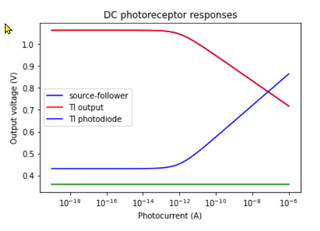.
</div>

## Preparation for large signal transient (time-domain) simulations


The previous results should make sense before you continue. Both output voltages should be logarithmic with photocurrent and the TI circuit should clamp the $V_p$ voltage at exactly a constant value (because you have assumed that $A$ is infinite here).

Now we have equations we can use in ODE equations for time-domain simulations. In the prelab, you already derived the dynamical equations for the SF and TI photoreceptors. 


### Dynamical equations

Next we will code the dynamical equations for the source-follower and feedback photoreceptor using the `id_sub` function
for the currents. We need to write code for the right hand side equation for
```
dy / dt = f(t, y)
```
given initial condition
```
y(t0) = y0
```
The source follower only has one node so the output is a scalar derivative.
The TI photoreceptor has 2 nodes (the photodiode and output), so the output is a vector of 2 derivatives w.r.t. time.

## Exercise 2: Large signal transient response of source follower and active photoreceptors

As an example, below we define the function `sfdvdt(t,y,V_g=1.4,C_pd=100e-15)` RHS for the SF. The time derivative of the output voltage is the current
divided by the node capacitance. `sfdvdt` returns the time derivative $\dot(V)$ `vdot`:

In [ ]:
def sfdvdt(t,y,V_g=1.4,C_pd=100e-15): # fill in reasonable photodiode capacitance, e.g. 100fF
    vdot=  (id_sub(V_g=V_g, V_s=y)-I_pd(t))/C_pd
    return vdot

### Exercise 2.1: define RHS of ODE for TI receptor

<font color=#108ee9 markdown="1">

* Now you should do the same thing, but for the function `tidvdt(t,y,Ib,I_pd)` that returns the vectors of TI node voltages `[vpd_dot,vout_dot]` from the input time `t` (actually not used) and input vector `y=[vpd,vout]` which consists of the `vpd` input (photodiode)
and `vout` node voltages. The bias current `I_b` and time-varying input photocurrent `I_pd` are also inputs:
</font>

You will need to refer back your [prelab answers for photoreceptor dynamics](#photoreceptor-dynamics).

In [ ]:
def tidvdt(t,y,C_pd=100e-15,C_out=100e-15):
    """ Compute time derivatives of TI photoreceptor node voltages

    :param t: the time in s - it is used to get the input photocurrent from `I_pd_function(t)`
    :param y: the TI PD and output voltages vector `[vpd,vout]`
    :param C_pd: the photodiode cap in Coulombs
    :param C_out: the output capacitance

    :returns: the vector of photodiode/output voltage time derivatives
    """

    # TODO you fill in next parts from equations for TI photoreceptor.
    # NOTE a split view of the notebook is helpful here; you can use 
    # the vscode window splitting button at the top right of the screen to see your large signal equations
    # you should use the function 
    #       id_sub(V_g, V_s=0, V_d=1.8, U_T=U_T, I_0=I_0, kappa=kappa, V_e=V_e) = some function of vpd, vout, I_pd
    # and the parameters cout, cpd, V_e
    # together with the answer to the first prelab question about writing the large signal dynamical equations for the TI photoreceptor. 
    # Here are the parameters again
        # I_0= 1e-13 # FET off current - you measured it TODO check correct for classchip process
        # U_T= 25e-3# you better know this
        # kappa=.8 # choose a reasonable value
        # vdd=1.8 # power supply voltage
        # q=1.6e-19 # charge of electron
        # V_e=10 # Early voltage for the TI photoreceptor amplifier input FET that we will use later. 1V is very small and would be less than what you would get from minimum length FET
    # Remember, g_out = Idsat/V_e =I_b/V_e but the id_sub equation already handles the drain conductance of Mn for you. 
    # You don't need to worry about the Mp (Ib) drain conductance; you can assume it is a perfect current source
    # same for Mfb, the only thing that matters here is the saturated Vgs current, drain voltage by default is already Vdd

    vpd=y[0]
    vout=y[1]
    # remember, drain current of nfet is id_sub(gate, source, drain=vdd)
    
    vpd_dot=(id_sub(vout, vpd)-I_pd_function(t))/C_pd
    vout_dot=(I_b-id_sub(vpd,0,vout))/C_out
    yout=[vpd_dot, vout_dot]
    return yout


In [ ]:

# check to make sure it makes sense by putting in a DC operating point and check that the derivatives are close to zero
# I_b=10nA and photocurrent I_p=4.44fA are vpd=359.78m vout=431.87m
I_b=10e-9
t=0
vpd=.3585 # if you increase this, vout_dot will get more negative
vout=.4 # if you increase this, vpd_dot will get more positive
y=[vpd,vout]
ydot=tidvdt(t,y)
print(f'for input [vpd,vout]={y} we get [vpd_dot, vout_dot]={ydot}')


    

<div markdown="1" style=" width: 800px; border: 1px solid green; border-radius: 5px; /*background-color: #d1a2a2; */ margin: 1em 0 1em 4em; padding: 1em 1em 0.5em 1em">

You should have gotten a result similar to this from the check:
```
for input [vpd,vout]=[0.3585, 0.4] we get [vpd_dot, vout_dot]=[0.02306191497545547, 170.34118964297124]
```
If not, either your equations are wrong, or you have not found the correct operating point to make both derivatives close to zero.

**We advise you not to continue until this result starts to make sense, otherwise your transient simulation of the next step will not work.**
</div>

### Exercise 2.2: Timestepping transient simulation of photoreceptors

Below we have written a timestepping simulation for the SF photoreceptor.
You should add the TI photoreceptor to the simulation so you can compare them to each other.
You may find issues with the simulator not responding to some of the edges in
the photocurrent. If this is the case, you can try to decrease tolerance (`rtol`
and `atol`), and also try different methods. Check[ `solve_ivp()` documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html) for the
different options.

Note that in the following transient solution, you might get a startup glitch particularly
for the TI photoreceptor because your TI DC solution
at the starting time is not quite correct. It means that the `V_pd` and `V_out` are not consistent,
and so the circuit will go through a short period of adjustment to come to the steady-state level.

<font color=#108ee9 markdown="1">

* Run the simulation below, modifying it until it makes sense. See the TODO items for where you need to write the TI model code. You can run it before you add your code to check the SF simulation result. 

**You may want to make a copy of the code cell and work on it.**
</font>

In [ ]:
import matplotlib.pyplot as plt # plotting
import numpy as np # for math
from scipy.integrate import solve_ivp # for timestepping ODEs

V_sf0= [1.1]# initial condition of v, just guess it to be approx Vg-a bit, e.g. 1.4-.3
sf_sol=solve_ivp(sfdvdt, (time_basis[0],time_basis[-1]),V_sf0, t_eval=time_basis,
                 rtol=1e-10,atol=1e-20, method='LSODA',
                 #rtol=1e-9,atol=1e-20, method='Radau',
                 args=(1.4,C_pd)) # args are the inputs to sfdvdt after t,y
# output is sol.t and sol.y
if sf_sol.message is not None:
    print(sf_sol.message)
v_sf=sf_sol.y[0]
t_sf=sf_sol.t



# TODO you can solve the TI by filling in below
# check DC output
ib=I_b
ip=I_pd(0)
V_ti0=ti_dc(I_b,ip)
print(f'DC output of TI with I_b={ef(I_b)} and I_pd={ef(ip)} are vpd={ef(V_ti0[0])} vout={ef(V_ti0[1])}')

C_out=1e-15
# ti_sol=solve_ivp(tidvdt, (time_basis[0],time_basis[-1]),V_ti0, t_eval=time_basis,
#                 rtol=1e-10, atol=1e-21, method='Radau',
#                 # rtol=1e-9, atol=1e-19, method='LSODA',
#                 args=(C_pd,C_out)) # args are the inputs to sfdvdt
# above, if your tidvdt is defined as tidvdt(t,y,C_pd=100e-15,C_out=100e-15), then args needs to define only C_pd and C_out
# (everything past the t,y args)

## output is sol.t and sol.y
# if ti_sol.message is not None:
#    print(f'\nPLEASE CHECK THIS MESSAGE: ****************** {ti_sol.message}\n')
# v_ti=ti_sol.y[1]
# t_ti=ti_sol.t
# v_pd=ti_sol.y[0]
# t_pd=ti_sol.t

# use this plotting style to put several plots sharing same x-axis
# we will plot V_sf together with the input photocurrent
# using another axis since it is volts, not current, and linear not log
fig=plt.figure(figsize=(12,8))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122, sharex = ax1)

ax1.plot(time_basis,photocurrent_waveform,'g')
ax1.set_yscale('log')
ax1.set_xscale('linear')
ax1.tick_params(axis='y', colors='green')
ax1.set_xlabel('t [s]')
ax1.set_ylabel('I_pd [A]')
ax1.title.set_text('Source Follower Photoreceptor')
ax2.title.set_text('Transimpendance Photoreceptor')

ax3=ax1.twinx()
ax3.plot(t_sf,v_sf,'r-')
ax3.tick_params(axis='y', colors='red')
ax1.legend(['Input current'], loc='upper left')
ax3.legend(['Vout'], loc='upper right')

ax2.set_yscale('log')
ax2.set_xlabel('t [s]')

ax2.tick_params(axis='y', colors='green')
ax2.set_xscale('linear')


ax2.plot(time_basis,photocurrent_waveform,'g',)
ax2.legend(['Input current'], loc='upper left')

# TODO: Uncomment for TI photoreceptor
# ax4=ax2.twinx()
# ax4.set_ylabel('Voltage [V]')
# #ax4.set_ylim([0.4,0.8])
# ax4.plot(t_ti, v_ti,'b-',t_pd,v_pd,'m-')
# ax4.tick_params(axis='y', colors='blue')
# ax4.legend(['Vout', 'Vpd'], loc='upper right')


<div markdown="1" style=" width: 800px; border: 1px solid green; border-radius: 5px; /*background-color: #d1a2a2; */ margin: 1em 0 1em 4em; padding: 1em 1em 0.5em 1em">

Before you run the TI simulation, you should have seen this from running the SF simulation. It is missing the SF solution in the right plot.

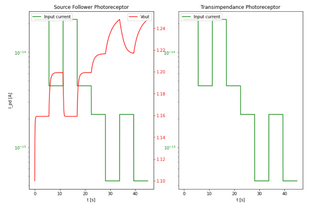.
</div>

<div markdown="1" style=" width: 900px; border: 1px solid purple; border-radius: 5px;  margin: 1em 0 1em 4em; padding: 1em 1em 0.5em 1em">

Answer: Here is the solution code.
</div>

<div markdown="1" style=" width: 800px; border: 1px solid red; border-radius: 5px; /*background-color: #d1a2a2; */ margin: 1em 0 1em 4em; padding: 1em 1em 0.5em 1em">

When you run your code, check to see if you got the message

`message: 'Required step size is less than spacing between numbers.'`

If so, then you will need to adjust your simulation solver parameters. Check[ `solve_ivp()` documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html) for the
different options.
</div>


<div markdown="1" style=" width: 1000px; border: 1px solid green; border-radius: 5px; /*background-color: #d1a2a2; */ margin: 1em 0 1em 4em; padding: 1em 1em 0.5em 1em">

You should come to a result similar to this

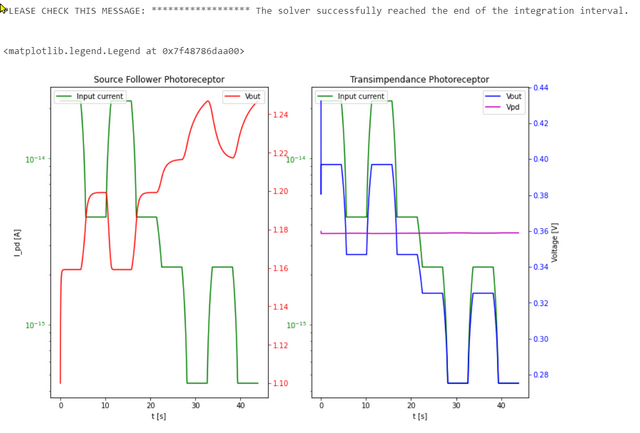

If not, please check your `tidvdt` equations again, and verify that they make sense for a DC operating point.
</div>

<font color=blue markdown="1">

* Can you see the speedup?  It might be too quick to measure by eye from the plot. 

You can take your solution and zoom up on part of it to see if you can quantify the speedup provided by the active transimpedance loop of the TI photoreceptor.
</font>

Please comment

<div markdown="1" style=" width: 900px; border: 1px solid purple; border-radius: 5px;  margin: 1em 0 1em 4em; padding: 1em 1em 0.5em 1em">

Answer: .
</div>


## Exercise 3: Small signal modeling (Optional)

You already did the most difficult part which is the large signal modeling. Now we will fix
the operating point around some DC level and compute the small signal transfer functions.
From these we can see the cutoff frequencies and stability.

This exercise is optional because the exercise is already long, but if you do it you may gain a better understanding of the (perhaps) cryptic 2nd-order $H_{\rm TI}$ transfer function.


<font color=#108ee9 markdown="1">

* Using the theory that you did in your prelab, plot the magnitude of the transfer functions versus frequency, assuming reasonable values for $\tau_{in}$, $\tau_{out}$, etc
and an intermediate DC value of photocurrent, e.g. $I_{pd}$=1pA. 
</font> You can assume that the bias current of the amplifier
for the feedback photoreceptor is $I_b$=10nA and $V_e$=10V.

  * Remember that frequency in radians per second is $w$=$2 \pi f$ where $f$ is frequency in Hertz.
  * You can use numpy to compute the magnitude of the complex transfer function by using $s$=$jw$ where $j$ is $\sqrt{-1}$.
  * Assume the DC photocurrent is still photocurrent_amps from above.

The code in the next cell sets up the plotting for you; check the <font color=blue>TODO</font> items for what you need to fill in.

In [ ]:
import matplotlib.pyplot as plt # plotting
import numpy as np # for math

Ipd_dim=photocurrent_total_amps

freq = np.logspace(-2,6,100) # plot from 1kHz to 1GHz
w=2*np.pi*freq
tau_sf = C_pd*U_T/Ipd_dim # tau_sf = C_pd/gs_sf
H_sf = U_T/(np.sqrt(np.square(w*tau_sf)+1))
sf_cutoff_hz=1/(2*np.pi*tau_sf)

print(f'source follower photodiode capacitance C_pd={ef(C_pd)}F and tau_sf={ef(tau_sf)}s\n'
      f'SF cutoff frequency: {ef(sf_cutoff_hz)}Hz')

# TODO TI photoreceptor
tau_in=...
tau_out=...
A=...
H_ti=...

ti_cutoff_hz=sf_cutoff_hz*(kappa*A+1)

print(f'transimpedance TI cutoff frequency: {ef(ti_cutoff_hz)}Hz')


fig,ax1=plt.subplots(sharex=True)
#ax1.plot(freq,H_sf,'b')
ax1.plot(freq,H_sf,'b',freq,H_ti,'r')
# ax1.plot(sf_cutoff_hz,'o')
#ax1.set_ylim([0,None])
ax1.set_yscale('log')
ax1.set_xscale('log')
#ax1.tick_params(axis='y', colors='green')
ax1.set_xlabel('f [Hz]')
ax1.set_ylabel('|H(s)| [V/(A/A)]')
ax1.grid()

<font color=#108ee9 markdown="1">

* Comment on your results. Can you see the effect of feedback on the bandwidth in the TI circuit? Can you observe
some ringing? I.e. is the circuit overdamped or underdamped at this $I_b$ and $I_{pd}$?
</font>

<div markdown="1" style=" width: 900px; border: 1px solid purple; border-radius: 5px;  margin: 1em 0 1em 4em; padding: 1em 1em 0.5em 1em">

Answer: .
</div>

# Postlab

<font color=#108ee9 markdown="1">

* Write a summary/conclusion of your theory and experiemental results.
</font>

<div markdown="1" style=" width: 900px; border: 1px solid purple; border-radius: 5px;  margin: 1em 0 1em 4em; padding: 1em 1em 0.5em 1em">

Answer: .
</div>

## What we expect you to learn
Please see the [NE1 exam preparation guide](https://drive.google.com/file/d/1nOq3UbcEv_ik425VBYqcH9hAET7FyIeP/view?usp=drive_link)


## Congratulations

Wish you joy and happiness!